In [38]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchmetrics

plt.style.use('ggplot')

iris = datasets.load_iris()

In [39]:
# assign data to variables X and y
X, y = iris.data, iris.target

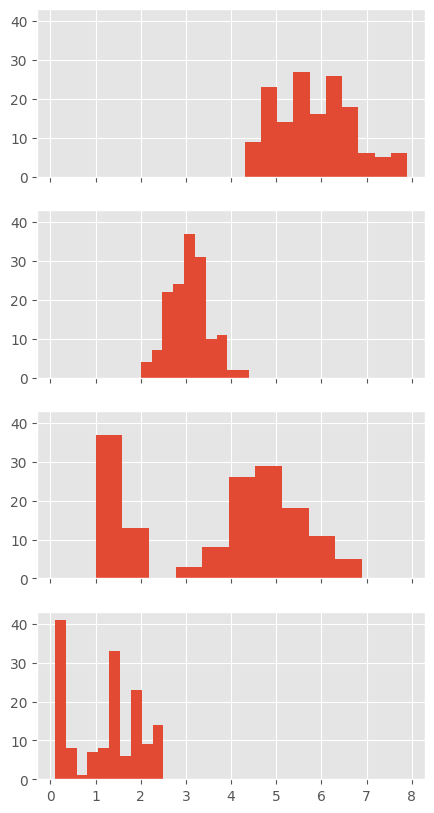

In [40]:
fig, ax = plt.subplots(X.shape[1], sharey = True, sharex = True, figsize = (5,10))

for i in range(X.shape[1]):
    ax[i].hist(X[:,i])

In [41]:
# In the charts above we can see data are focused on varied sets
# We standardize each columns by subtract mean and divide by std
X = (X-X.mean(0))/X.std(0)

In [42]:
# y has 3 unique values
# encode this vector into 3 true-false vectors
encoder = OneHotEncoder(sparse_output=False)
y_1hot = encoder.fit_transform(y[:,np.newaxis]) # change shape of y in 150x1 (dim=2)

In [43]:
# split data for training and test sets, 15% for test set because whole set is small
X_train, X_test, y_train, y_test = train_test_split(X, y_1hot, test_size = 0.15, shuffle = True,
                                                    stratify = y, random_state = 21)

In [44]:
# create tensor datasets
dataset_train, dataset_test = map(lambda x: TensorDataset(torch.tensor(x[0]).float(), torch.tensor(x[1]).long()),
                                  ((X_train, y_train),(X_test, y_test)))

In [45]:
# create Dataloaders
dataloader_train, dataloader_test = map(lambda x: DataLoader(x, batch_size = 6, shuffle = True),
                                        (dataset_train, dataset_test))

---

In [46]:
# create model of neural network
model = nn.Sequential(nn.Linear(4,8),
                      nn.ReLU(),
                      nn.Linear(8,3))

In [47]:
# initiate loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.95)

In [48]:
# take one data
features, target = next(iter(dataloader_train))

In [49]:
optimizer.zero_grad()

for i in range(500):
    pred = model(features)
    loss = criterion(pred, target.float())
    loss.backward()
    optimizer.step()

In [50]:
print(f"loss= {loss.item():.2f},\nprediction= {pred.softmax(dim=-1).tolist()},\ntarget= {target.tolist()}")

loss= 4.45,
prediction= [[1.0, 0.0, 0.0], [2.5018528978877425e-35, 2.5636318155136673e-12, 1.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0]],
target= [[1, 0, 0], [0, 1, 0], [1, 0, 0], [0, 0, 1], [0, 0, 1], [1, 0, 0]]


---

In [51]:
def train_network(model, optimizer, dataloader_train, dataloader_test, num_epochs):
    # initiate loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    metric = torchmetrics.Accuracy(task= 'multiclass', num_classes = 3)
    
    loss_train_epoch = []
    loss_test_epoch = []
    accuracy_train_epoch = []
    accuracy_test_epoch = []

    train_len = len(dataloader_train)
    test_len = len(dataloader_test)
    
    for _ in range(num_epochs):
        training_loss = 0.0
        for features, target in dataloader_train:
            optimizer.zero_grad()
            pred = model(features)
            loss = criterion(pred, target.float())
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            acc = metric(pred.softmax(dim = -1), target.argmax(dim = -1))
        acc = metric.compute()
        accuracy_train_epoch.append(acc)
        metric.reset()
        loss_train_epoch.append(training_loss/train_len)

        validation_loss = 0.0
        model.eval()
        with torch.no_grad():
            for features, target in dataloader_test:
                pred = model(features)
                loss = criterion(pred, target.float())
                validation_loss += loss
                acc = metric(pred.softmax(dim = -1), target.argmax(dim = -1))
            acc = metric.compute()
            accuracy_test_epoch.append(acc)
            metric.reset()
            loss_test_epoch.append(validation_loss/test_len)
        model.train()
    return loss_train_epoch, loss_test_epoch, accuracy_train_epoch, accuracy_test_epoch 

---

## Training model

In [52]:
# create model of neural network
model = nn.Sequential(nn.Linear(4,10),
                      nn.ReLU(),
                      nn.Linear(10,3))

In [53]:
# initiate loss function and optimizer
num_epochs = 200

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.95)

metric = torchmetrics.Accuracy(task= 'multiclass', num_classes = 3)

In [54]:
optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.95)

loss_train_epoch, loss_test_epoch, accuracy_train_epoch, accuracy_test_epoch = train_network(model, optimizer, dataloader_train, dataloader_test, num_epochs)

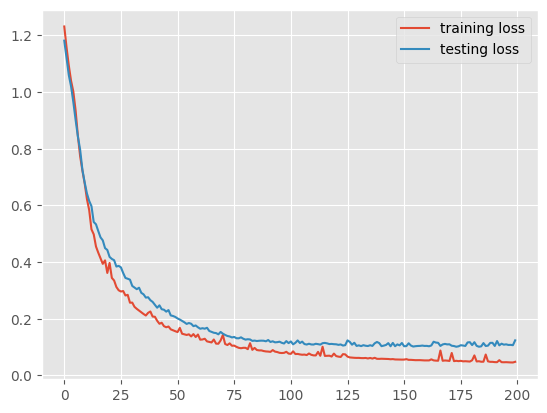

In [55]:
plt.plot(loss_train_epoch, label = 'training loss')
plt.plot(loss_test_epoch, label = 'testing loss')
plt.legend()
plt.show();

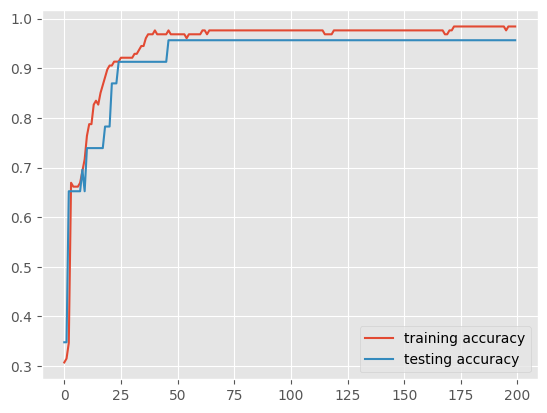

In [56]:
plt.plot(accuracy_train_epoch, label = 'training accuracy')
plt.plot(accuracy_test_epoch, label = 'testing accuracy')
plt.legend()
plt.show();

---

## Regularization

In [57]:
# try to minimaze overfitting effect by adding dropout layer
p_dropout = np.arange(0.1,0.6,0.1)
we_decay = [1e-3,1e-4]

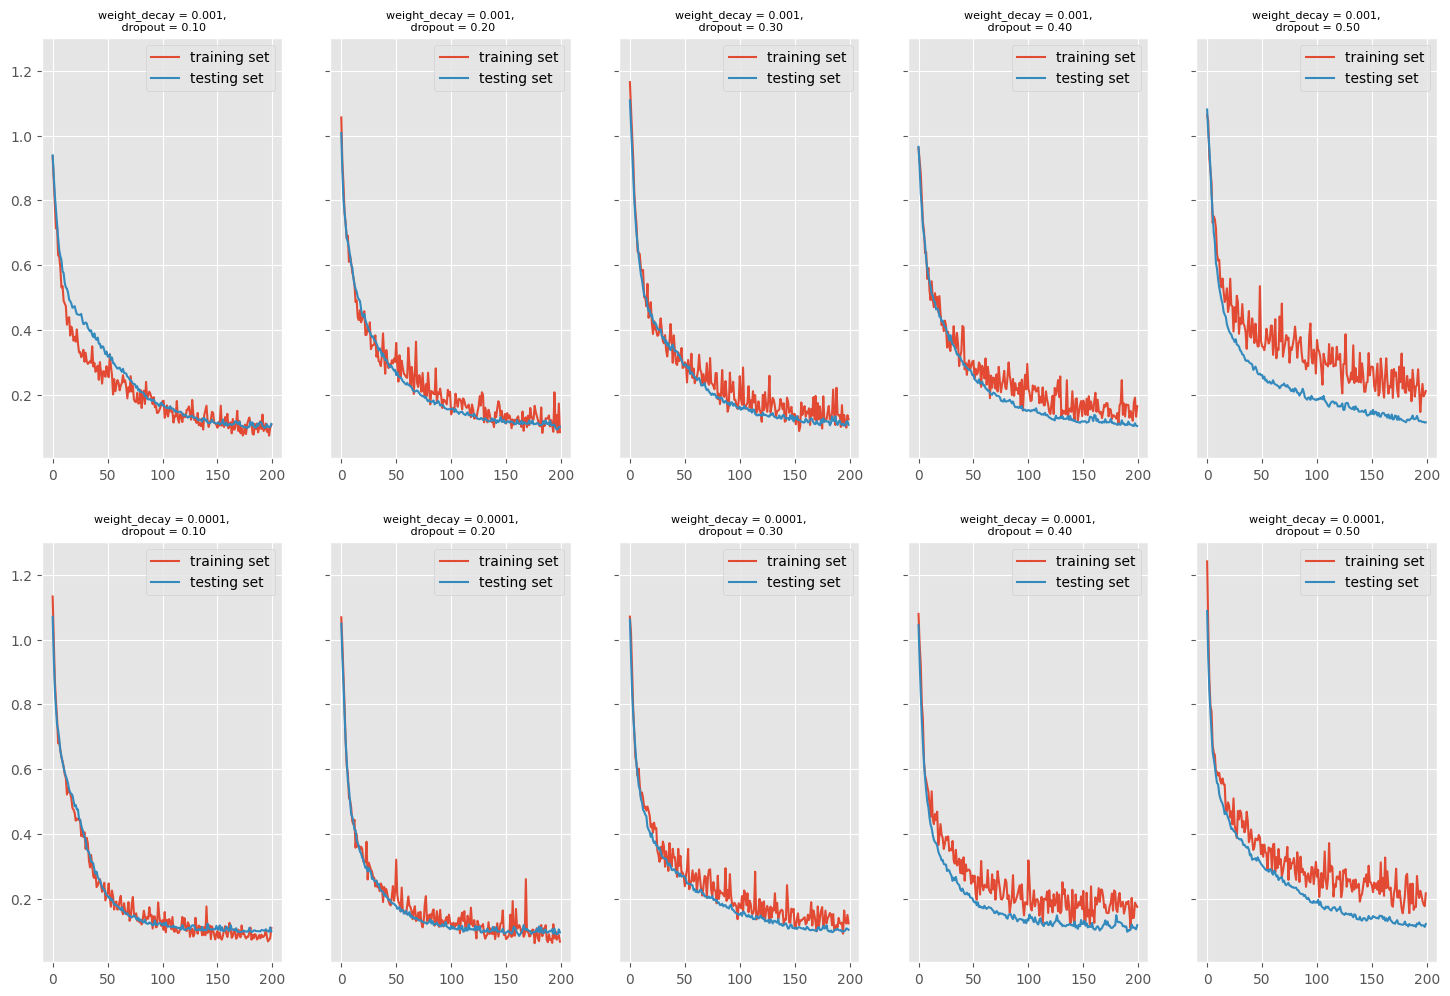

In [58]:
fig, ax = plt.subplots(2,5, sharey = True, figsize = (18,12))
i, j = 0, 0

for p in p_dropout:
    i = 0
    for w in we_decay:
        model = nn.Sequential(nn.Linear(4,10),
                          nn.ReLU(),
                          nn.Dropout(p=p),
                          nn.Linear(10,3))
        optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.95, weight_decay = w)
        loss_train_epoch, loss_test_epoch, accuracy_train_epoch, accuracy_test_epoch = train_network(model, optimizer, dataloader_train, dataloader_test, num_epochs)
        ax[i,j].plot(loss_train_epoch, label = 'training set')
        ax[i,j].plot(loss_test_epoch, label = 'testing set')
        ax[i,j].set_title(f'weight_decay = {w},\n dropout = {p:.2f}', fontsize = 8)
        ax[i,j].legend()
        i += 1
    j += 1

In [65]:
model = nn.Sequential(nn.Linear(4,10),
                          nn.ReLU(),
                          nn.Dropout(p=0.2),
                          nn.Linear(10,3))
optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.95, weight_decay = 1e-4)
loss_train_epoch, loss_test_epoch, accuracy_train_epoch, accuracy_test_epoch = train_network(model, optimizer, dataloader_train, dataloader_test, num_epochs)

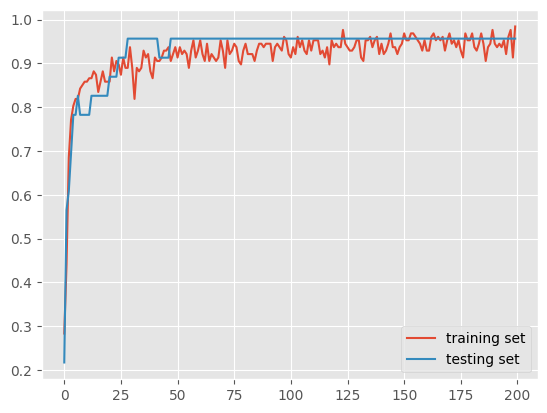

In [66]:
plt.plot(accuracy_train_epoch, label = 'training set')
plt.plot(accuracy_test_epoch, label = 'testing set')
plt.legend()
plt.show();

---

## Tuning hyperparameters

In [67]:
momentums = np.hstack((np.arange(0.85,0.99,0.05),0.99))
lrs = 10.0**(-np.arange(2,6))

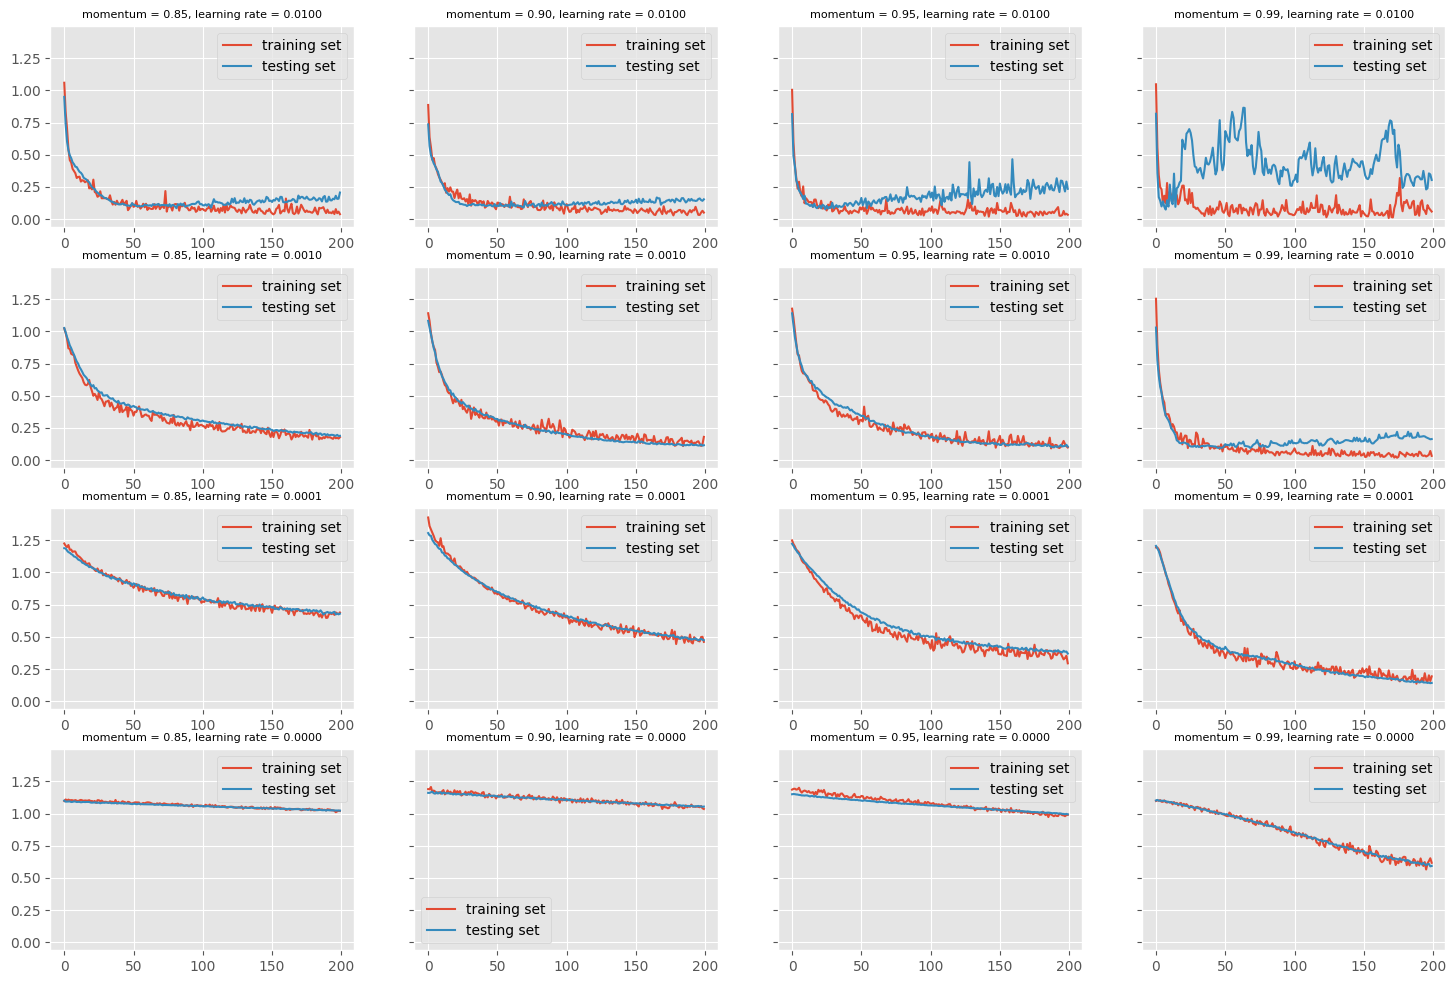

In [68]:
fig, ax = plt.subplots(4,4, sharey = True, figsize = (18,12))
i, j = 0, 0

for m in momentums:
    i = 0
    for l in lrs:
        model = nn.Sequential(nn.Linear(4,10),
                          nn.ReLU(),
                          nn.Dropout(p=0.2),
                          nn.Linear(10,3))
        optimizer = optim.SGD(model.parameters(), lr = l, momentum = m, weight_decay = 1e-4)
        loss_train_epoch, loss_test_epoch, accuracy_train_epoch, accuracy_test_epoch = train_network(model, optimizer, dataloader_train, dataloader_test, num_epochs)
        ax[i,j].plot(loss_train_epoch, label = 'training set')
        ax[i,j].plot(loss_test_epoch, label = 'testing set')
        ax[i,j].set_title(f'momentum = {m:.2f}, learning rate = {l:.4f}', fontsize = 8)
        ax[i,j].legend()
        i += 1
    j += 1

In [71]:
model_final = nn.Sequential(nn.Linear(4,10),
                          nn.ReLU(),
                          nn.Dropout(p=0.1),
                          nn.Linear(10,3))
optimizer = optim.SGD(model_final.parameters(), lr = 1e-3, momentum = 0.9, weight_decay = 1e-3)
loss_train_epoch, loss_test_epoch, accuracy_train_epoch, accuracy_test_epoch = train_network(model_final, optimizer, dataloader_train, dataloader_test, num_epochs)

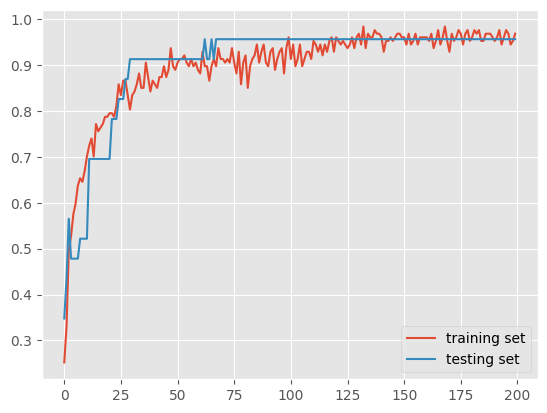

In [72]:
plt.plot(accuracy_train_epoch, label = 'training set')
plt.plot(accuracy_test_epoch, label = 'testing set')
plt.legend()
plt.show();

---

## Prediction

In [79]:
metric = torchmetrics.Accuracy(task= 'multiclass', num_classes = 3)

pred = model_final(torch.tensor(X_test).float())
acc = metric(pred.softmax(dim = -1), torch.tensor(y_test, dtype=torch.long).argmax(dim = -1))
metric.compute()
print('Accuracy:',acc)

Accuracy: tensor(0.9565)
